In [1]:
import jax
import numpy as np
import jax.numpy as jnp
import optax
import scipy.linalg
import scipy.signal
import torch
import matplotlib.pyplot as plt
from flax import linen as nn
from torch.utils.data import Dataset, DataLoader

def np_collate(batch):
    if isinstance(batch[0], np.ndarray):
        return np.stack(batch)
    elif isinstance(batch[0], (tuple,list)):
        transposed = zip(*batch)
        return [np_collate(samples) for samples in transposed]
    else:
        return np.array(batch)

In [2]:
# Setup seed 
torch.random.manual_seed(0)
np.random.seed(0)
key = jax.random.PRNGKey(0)

In [3]:
A = np.array([[0,1],[0,0]])
B = np.array([[0],[1]])
Q = np.array([[1,0],[0,1]])
R = np.array([[0.01]])
R_inv = scipy.linalg.inv(R)

P = scipy.linalg.solve_continuous_are(A,B,Q,R)

Build dynamics simulation

In [4]:
dt = 0.01
state_dim = A.shape[0]
u_dim = B.shape[1]
A_d, B_d, _, _, _ = scipy.signal.cont2discrete((A, B, np.eye(state_dim), np.eye(u_dim)), dt=dt)

def dynamics_step(x, u):
    return A_d @ x + B_d @ u


In [5]:
class ValueApproximator(nn.Module):
    @nn.compact
    def __call__(self, x):
        y = nn.Dense(128)(x)
        y = jnp.sin(y)
        y = nn.Dense(128)(y)
        y = jnp.sin(y)
        y = nn.Dense(64)(y)
        y = jnp.einsum('...i,...i->...', y, y) + 1e-3 * jnp.einsum('...i,...i->...', x, x)

        return y.squeeze()

Generate datasets

In [6]:
metric = 1e-4
xs = np.random.uniform(low=-1,high=1, size=(2**16, 2))
norms = np.array([x.T @ x for x in xs])
running_costs = np.where(norms > metric, 1, 0)

class StateDataset(Dataset):
    def __init__(self, xs, running_costs):
        super().__init__()
        self.xs = xs
        self.running_costs = running_costs
    def __len__(self):
        return self.xs.shape[0]
    def __getitem__(self, index):
        return self.xs[index], self.running_costs[index]
    
dataset = StateDataset(xs, running_costs)
dataloader = DataLoader(dataset, batch_size=256, shuffle=True, collate_fn=np_collate, drop_last=False)

Code for test policy

In [7]:
def test_learned_policy(model, model_params, model_states, x0, T=3):

    @jax.jit
    def get_control(x):
        v_gradient, _ = jax.grad(model.apply, argnums=1, has_aux=True)({'params': model_params, **model_states}, x, mutable=list(model_states.keys()))
        u = -jnp.sign(v_gradient @ B) 
        return u

    ts = np.arange(0, T, dt)
    xs_learned = [x0]
    xs_lqr = [x0]
    us_learned = []
    us_lqr = []
    optimal_t_lqr = T
    optimal_t_learned = T

    for t in ts:
        us_learned.append(np.array(get_control(xs_learned[-1])))
        xs_learned.append(dynamics_step(xs_learned[-1], us_learned[-1]))
        if xs_learned[-1].T @ xs_learned[-1] <= metric:
            optimal_t_learned = min(t, optimal_t_learned)
        us_lqr.append(np.clip(-R_inv @ B.T @ P @ xs_lqr[-1], -1, 1))
        xs_lqr.append(dynamics_step(xs_lqr[-1], us_lqr[-1]))
        if xs_lqr[-1].T @ xs_learned[-1] <= metric:
            optimal_t_lqr = min(t, optimal_t_lqr)
    
    xs_learned = np.array(xs_learned)
    us_learned = np.array(us_learned)
    xs_lqr = np.array(xs_lqr)
    us_lqr = np.array(us_lqr)

    plt.figure()
    plt.plot(ts, xs_learned[:-1, 0], label=f"pos learned")
    plt.plot(ts, xs_learned[:-1, 1], label=f"vel learned")
    plt.vlines(optimal_t_learned, -0.1, 0.5, 'b', linestyles='dashed', label="learned policy optimal t cutting off")
    plt.plot(ts, xs_lqr[:-1, 0], label=f"pos lqr")
    plt.plot(ts, xs_lqr[:-1, 1], label=f"vel lqr")
    plt.vlines(optimal_t_lqr, -0.1, 0.5, 'r', linestyles='dashed', label="lqr policy optimal t cutting off")
    plt.legend()
    plt.xlabel("time")
    plt.ylabel("states")
    plt.title("double integrator optimal time control")

    plt.figure()
    plt.plot(ts, us_learned[:, 0], label=f"input learned")
    plt.plot(ts, us_lqr[:, 0], label=f"input lqr")
    plt.legend()
    plt.xlabel("time")
    plt.ylabel("input")
    plt.title("input vs time")

In [8]:
value_function_approximator = ValueApproximator()
key, key_to_use = jax.random.split(key)
model_variables = value_function_approximator.init(key_to_use, jnp.zeros((1,2)))
model_states, model_params = model_variables.pop('params')
del model_variables
optimizer = optax.adam(learning_rate=1e-3)
optimizer_states = optimizer.init(model_params)

def hjb_loss(params, states, xs, running_costs):
    def get_v_gradient(params, states, x):
        return jax.grad(value_function_approximator.apply, argnums=1, has_aux=True)({'params': params, **states}, x, mutable=list(states.keys()))
    def loss(x, running_cost):
        v_gradient, updated_states = get_v_gradient(params, states, x)
        u = -jnp.sign(v_gradient @ B) 
        x_dot = A @ x + B @ u
        v_dot = v_gradient.T @ x_dot
        loss = jnp.abs(v_dot + running_cost)
        return loss, updated_states    
    batch_losses, updated_states = jax.vmap(loss)(xs, running_costs)
    return jnp.mean(batch_losses), updated_states

@jax.jit
def params_update(params, states, optimizer_state, xs, running_costs):
    (loss, updated_states), hjb_grad = jax.value_and_grad(hjb_loss, has_aux=True)(params, states, xs, running_costs)
    updates, optimizer_state = optimizer.update(hjb_grad, optimizer_state)
    params = optax.apply_updates(params, updates)
    return params, updated_states, optimizer_state, loss

losses = []
for epoch in range(100):
    total_loss = 0
    for i, (xs, running_costs) in enumerate(dataloader):
        model_params, model_states, optimizer_states, loss = params_update(model_params, model_states, optimizer_states, xs, running_costs)
        total_loss += loss
    losses.append(total_loss / len(dataloader))
    if (epoch+1) % 10 == 0:
        print(f"epoch:{epoch+1} loss:{total_loss / len(dataloader)}")


epoch:10 loss:0.06465891003608704
epoch:20 loss:0.06461028009653091
epoch:30 loss:0.05235343426465988
epoch:40 loss:0.04057149589061737
epoch:50 loss:0.04957146197557449
epoch:60 loss:0.03370058909058571
epoch:70 loss:0.030359024181962013
epoch:80 loss:0.03349056839942932
epoch:90 loss:0.027384907007217407
epoch:100 loss:0.024904917925596237


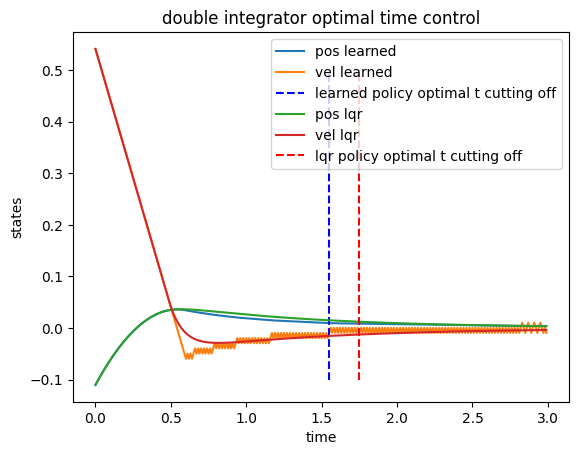

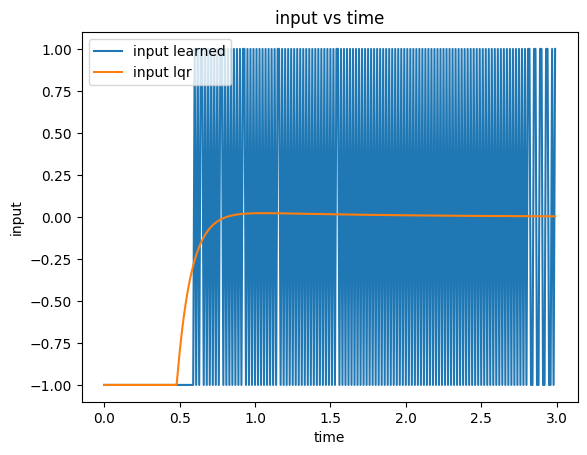

In [9]:
x0 = np.random.uniform(low=-1,high=1, size=(2,))
test_learned_policy(value_function_approximator, model_params, model_states, x0)

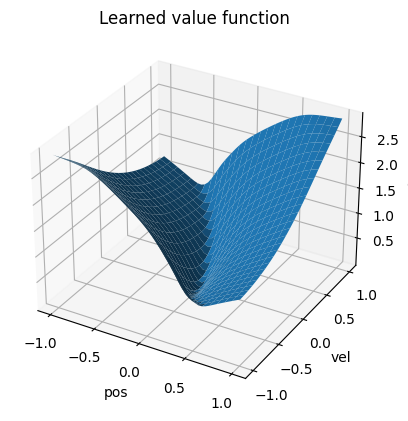

In [11]:
def visualize_learned_value_landscope(model, model_params, model_states, x_direction, y_direction, 
                        x_range=np.linspace(-1, 1, 51), y_range=np.linspace(-1, 1, 51), title="Learned value function"):
    """
    This function help to draw value function landscope for learn function,
    
    x_direction and y_direction should be perpenticular to each other, suppose a_i \in x_range, b_i \in y_range, then x_i = a_i * x_direction + b_i * y_direction.
    This is prepare for visualize state dimension higher than 2.

    Args:
        model: nn network object
        model_params: params for learned nn networks
        model_states: params for neural network states such as bn statistics
        x_direction: x axis direction
        y_direction: y axis direction
        x_range: the ranges for x direction
        y_range: the range for y direction
    """
    

    quick_apply = jax.jit(model.apply, static_argnames=["train"])
    X, Y = np.meshgrid(x_range, y_range)
    v_learned = np.zeros_like(X)

    for i in range(X.shape[0]):
        for j in range(Y.shape[1]):
            x = X[i,j] * x_direction
            x += Y[i,j] * y_direction
            v_learned[i,j] = quick_apply({"params":model_params, **model_states}, x)

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(X, Y, v_learned)
    ax.set_xlabel(f"pos")
    ax.set_ylabel(f"vel")
    ax.set_zlabel('value')
    plt.title(title)


x_direction = np.array([1,0])
y_direction = np.array([0,1])
visualize_learned_value_landscope(value_function_approximator, model_params, model_states, x_direction=x_direction, y_direction=y_direction, title="Learned value function for Double integrator optimal time control")